In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import scipy
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d  

### VIF

In [9]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/xtonev/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
ort10_coltar10 = pd.read_csv('ort10_coltar10_mean.csv', header=None).values
ort10_colfeat10 = pd.read_csv('ort10_colfeat10_mean.csv', header=None).values
ort20 = pd.read_csv('ort20_mean.csv', header=None).values
ort5_coltar10_colfeat5 = pd.read_csv('ort5_coltar10_colfeat5_mean.csv', header=None).values
ort5_coltar15 = pd.read_csv('ort5_coltar15_mean.csv', header=None).values
ort10_coltar5_colfeat5 = pd.read_csv('ort10_coltar5_colfeat5_mean.csv', header=None).values
ort5_colfeat15 = pd.read_csv('ort5_colfeat15_mean.csv', header=None).values
ort15_colfeat5 = pd.read_csv('ort15_colfeat5_mean.csv', header=None).values
ort5_coltar5_colfeat10 = pd.read_csv('ort5_coltar5_colfeat10_mean.csv', header=None).values

ort10_coltar10_data = pd.read_csv('ort10_coltar10_data.csv', header=None)
ort10_colfeat10_data = pd.read_csv('ort10_colfeat10_data.csv', header=None)
ort20_data = pd.read_csv('ort20_data.csv', header=None)
ort5_coltar10_colfeat5_data = pd.read_csv('ort5_coltar10_colfeat5_data.csv', header=None)
ort5_coltar15_data = pd.read_csv('ort5_coltar15_data.csv', header=None)
ort10_coltar5_colfeat5_data = pd.read_csv('ort10_coltar5_colfeat5_data.csv', header=None)
ort5_colfeat15_data = pd.read_csv('ort5_colfeat15_data.csv', header=None)
ort15_colfeat5_data = pd.read_csv('ort15_colfeat5_data.csv', header=None)
ort5_coltar5_colfeat10_data = pd.read_csv('ort5_coltar5_colfeat10_data.csv', header=None)

In [4]:
true_results = [
    ort10_coltar10,
    ort10_colfeat10,
    ort20,
    ort5_coltar10_colfeat5,
    ort5_coltar15,
    ort10_coltar5_colfeat5,
    ort5_colfeat15,
    ort15_colfeat5,
    # ort5_coltar5_colfeat10
]
verify_results = [
    ort5_coltar5_colfeat10
]

In [5]:
datasets = [
    ort10_coltar10_data,
    ort10_colfeat10_data,
    ort20_data,
    ort5_coltar10_colfeat5_data,
    ort5_coltar15_data,
    ort10_coltar5_colfeat5_data,
    ort5_colfeat15_data,
    ort15_colfeat5_data,
    # ort5_coltar5_colfeat10_data
]
verify_datasets = [
    ort5_coltar5_colfeat10_data
]

In [82]:
vifs = []

for j in range(len(datasets)):
    datasets[j].columns = [str(chr(i + 97)) for i in range(22)]
    vifs.append([])
    
    for k in range(50, len(datasets[j]), 50):
        features = "+".join(map(str, datasets[j].iloc[:k,:-1].columns))
        y, X = dmatrices('v ~' + features, datasets[j], return_type='dataframe')
    
        vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
        vif[np.isinf(vif)] = 1e10
        vifs[j].append(vif)

In [83]:
verify_vifs = []

for j in range(len(verify_datasets)):
    verify_datasets[j].columns = [str(chr(i + 97)) for i in range(22)]
    verify_vifs.append([])
    
    for k in range(50, len(verify_datasets[j]), 50):
        features = "+".join(map(str, verify_datasets[j].iloc[:k,:-1].columns))
        y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')
    
        vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
        vif[np.isinf(vif)] = 1e10
        verify_vifs[j].append(vif)

In [87]:
class SSNet2D(nn.Module):
    def __init__(self, dim1=1, dim2=1, dim3=1):
        super().__init__()
        self.fc1 = nn.Linear(dim1, dim2)
        self.fc2 = nn.Linear(dim2, dim3)
        
        self.fc1.weight = nn.Parameter(Variable(torch.FloatTensor(np.ones((dim2, dim1))), requires_grad=True))
        self.fc1.bias = nn.Parameter(Variable(torch.FloatTensor(np.ones(dim2)), requires_grad=True))

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = torch.pow(x, -1)
        x = self.fc2(x)
        
        return x

In [88]:
net = SSNet2D(len(vifs[0][0]), len(true_results[0][:,-1]), len(true_results[0][:,-1]))
print(net)

data = [
    [vifs[i][j], true_results[i][:,-1]] 
    for i in range(len(datasets)) 
    for j in range(len(vifs[i]))
]

criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
#optimizer = optim.Adam(net.parameters(), lr=1e-3)

SSNet2D(
  (fc1): Linear(in_features=22, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=180, bias=True)
)


In [91]:
optimizer = optim.SGD(net.parameters(), lr=1)
for epoch in range(5001):
    full_loss = 0
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        X, Y = (Variable(torch.FloatTensor([X]), requires_grad=True), 
                Variable(torch.FloatTensor([Y]), requires_grad=False))
        
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        full_loss += loss.item()
        
    if (epoch % 100 == 0):
        print("Epoch {} - loss: {}, lr: {}".format(epoch, full_loss, optimizer.param_groups[0]['lr']))

Epoch 0 - loss: 0.6967475522833411, lr: 1
Epoch 100 - loss: 0.7052675127051771, lr: 1
Epoch 200 - loss: 0.7052520149445627, lr: 1
Epoch 300 - loss: 0.7051795763254631, lr: 1
Epoch 400 - loss: 0.7050912390404847, lr: 1
Epoch 500 - loss: 0.7049823598354124, lr: 1
Epoch 600 - loss: 0.7048468218708877, lr: 1
Epoch 700 - loss: 0.7046767568972427, lr: 1
Epoch 800 - loss: 0.7044627354189288, lr: 1
Epoch 900 - loss: 0.7041921944764908, lr: 1
Epoch 1000 - loss: 0.7038496704481076, lr: 1
Epoch 1100 - loss: 0.7034153787826654, lr: 1
Epoch 1200 - loss: 0.702863781596534, lr: 1
Epoch 1300 - loss: 0.7021623396431096, lr: 1
Epoch 1400 - loss: 0.7012692907010205, lr: 1
Epoch 1500 - loss: 0.7001306137535721, lr: 1
Epoch 1600 - loss: 0.6986762970045675, lr: 1
Epoch 1700 - loss: 0.6968150736065581, lr: 1
Epoch 1800 - loss: 0.6944264419726096, lr: 1
Epoch 1900 - loss: 0.6913499535585288, lr: 1
Epoch 2000 - loss: 0.6873679336276837, lr: 1
Epoch 2100 - loss: 0.6821775916032493, lr: 1
Epoch 2200 - loss: 0.67

KeyboardInterrupt: 

---

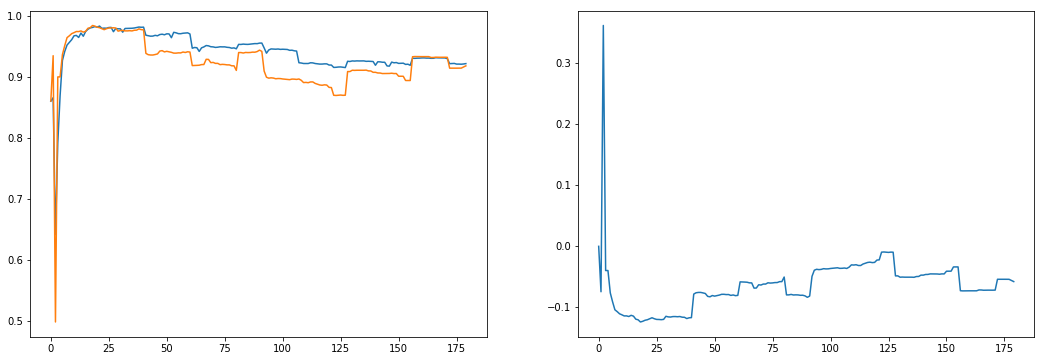

In [100]:
i = 0

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

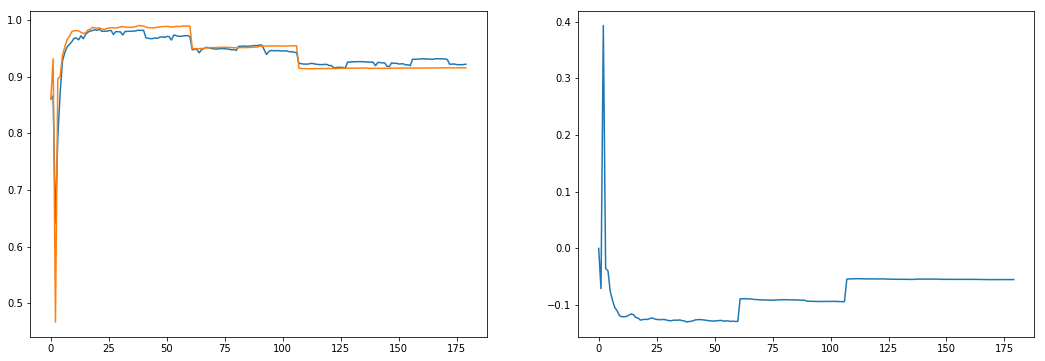

In [102]:
i = 1

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

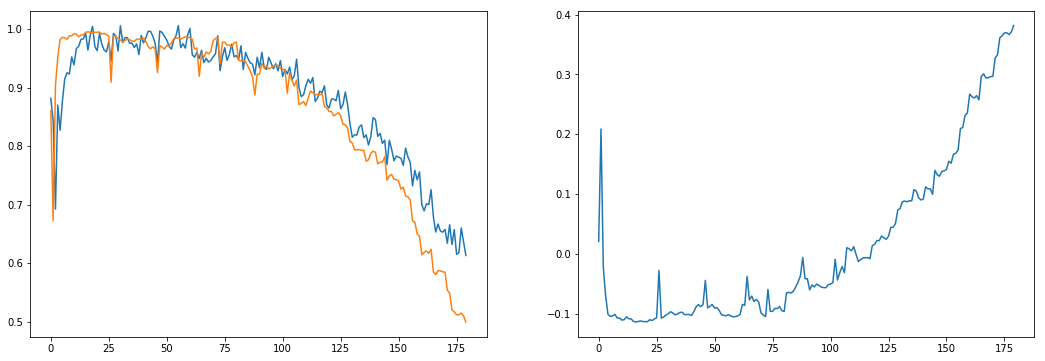

In [103]:
i = 3

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

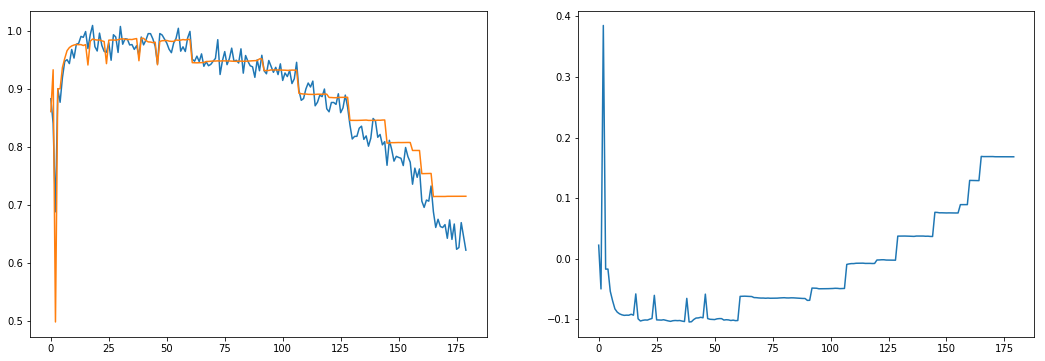

In [105]:
i = 5

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

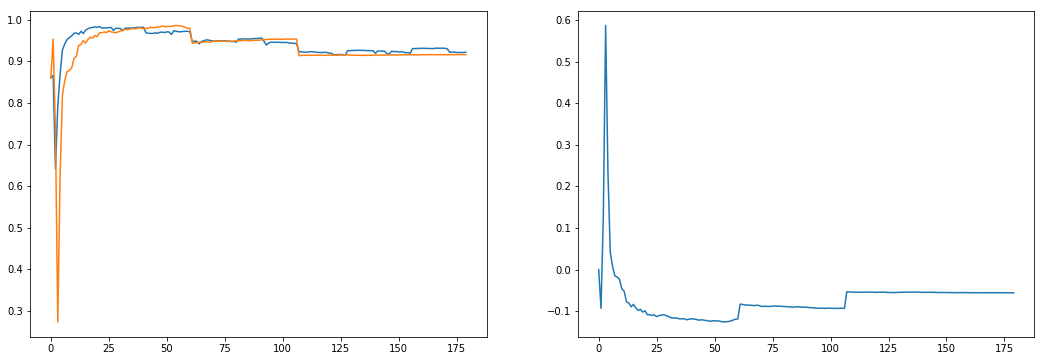

In [106]:
i = 7

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy())
ax.plot(true_results[i][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vifs[i][-1]))).data.numpy()[0] - true_results[i][:, -1])

---

In [ ]:
i = 7

In [108]:
m_ = true_results[i][:, -1].argmax()

In [109]:
m_

54

Let's consider $m^* == 54$

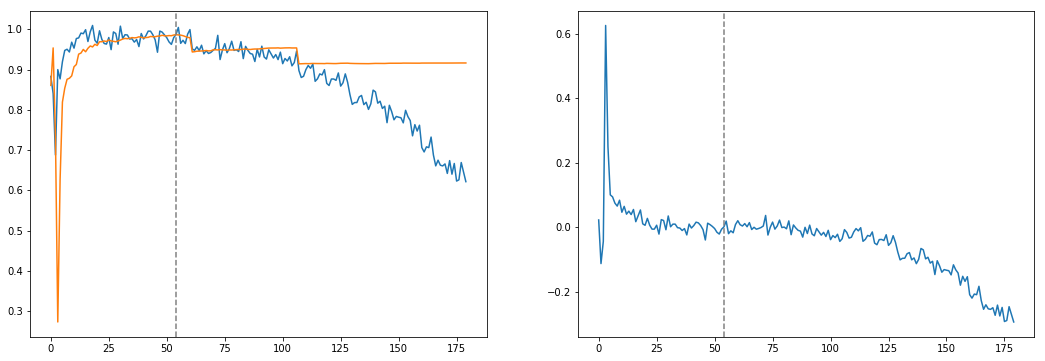

In [119]:
m = 5

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, verify_datasets[j].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

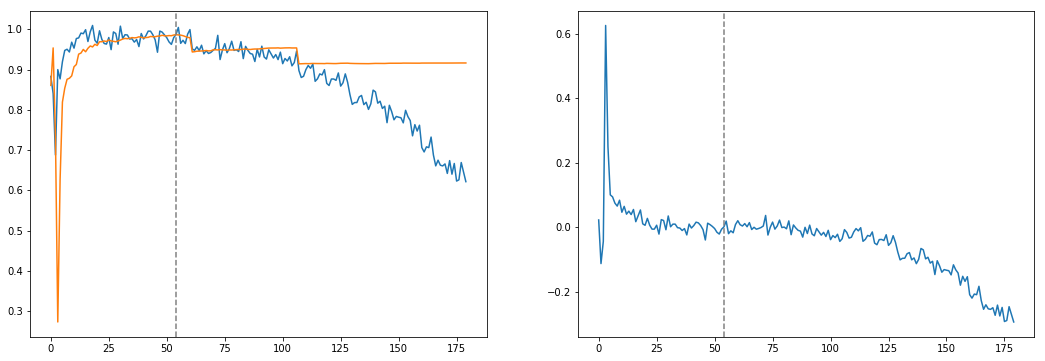

In [120]:
m = 15

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, verify_datasets[j].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

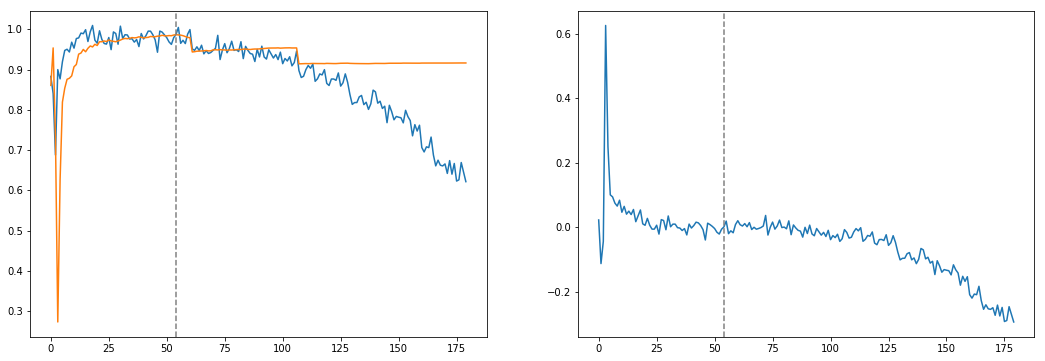

In [121]:
m = 25

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, verify_datasets[j].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

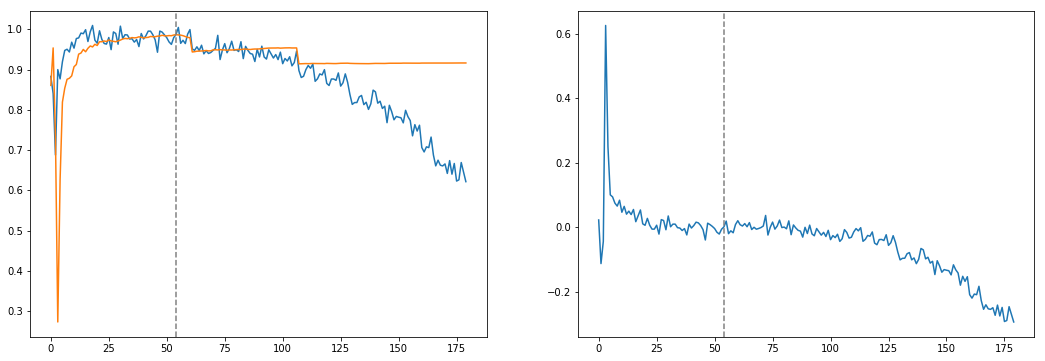

In [122]:
m = 50

fig = plt.figure(figsize=(18,6))

features = "+".join(map(str, verify_datasets[j].iloc[:m,:-1].columns))
y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')

vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
vif[np.isinf(vif)] = 1e10

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy())
ax.plot(true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
plt.axvline(x=m_, linestyle='--', color='grey')

---

In [123]:
all_diff = []
for m in range(1, m_):
    features = "+".join(map(str, verify_datasets[j].iloc[:m,:-1].columns))
    y, X = dmatrices('v ~' + features, verify_datasets[j], return_type='dataframe')

    vif = np.array(sorted([variance_inflation_factor(X.values, i) for i in range(X.shape[1])]))
    vif[np.isinf(vif)] = 1e10
    
    diff = (net(Variable(torch.FloatTensor(vif))).data.numpy() - true_results[i][:, -1])
    all_diff.append(diff)

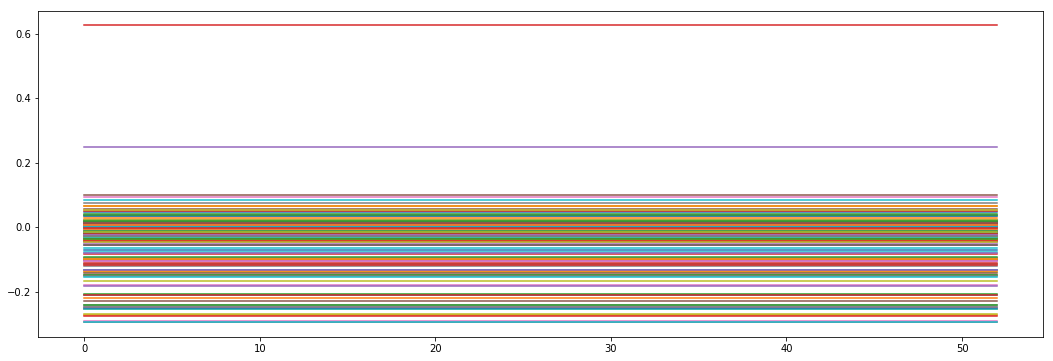

In [124]:
fig = plt.figure(figsize=(18,6))

plt.plot(all_diff)

Another dataset:

In [81]:
true_results[1][:, -1].argmax()

38

In [82]:
net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(vifs[1][-1])))]))).data.numpy()[0].argmax()

40

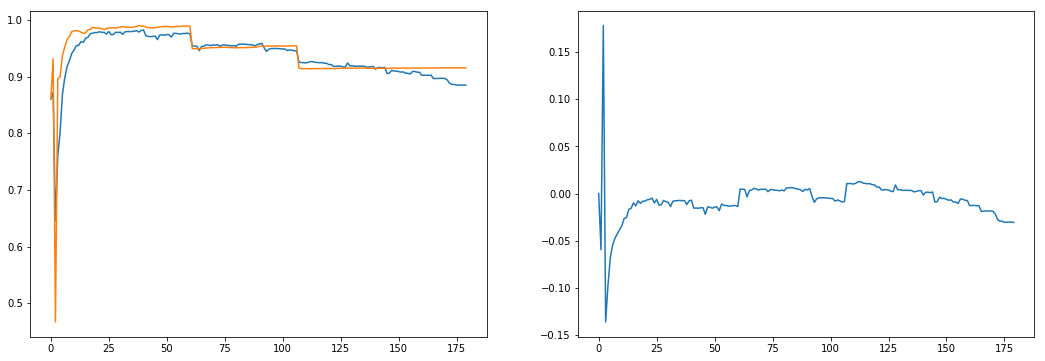

In [83]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(vifs[1][-1])))]))).data.numpy()[0])
ax.plot(true_results[1][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor([np.hstack(
    (x_input, sorted(vifs[1][-1])))]))).data.numpy()[0] - true_results[1][:, -1])

Let's consider $m^* == 38$

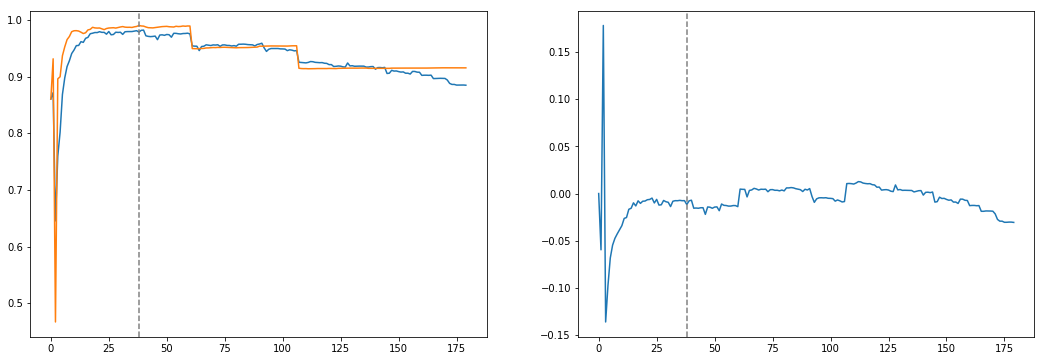

In [89]:
m = 5

fig = plt.figure(figsize=(18,6))

vif = np.linalg.inv(datasets[1][:m].corr().values).diagonal()

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(vif)))]))).data.numpy()[0])
ax.plot(true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor([np.hstack(
    (x_input, sorted(vif)))]))).data.numpy()[0] - true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

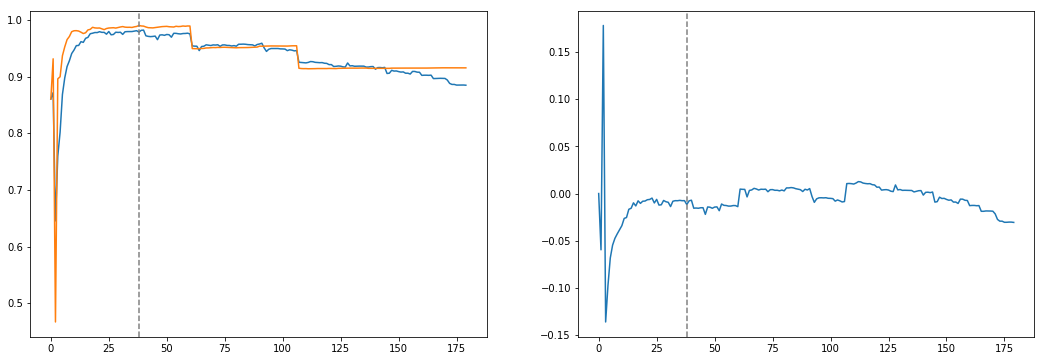

In [101]:
m = 15

fig = plt.figure(figsize=(18,6))

vif = np.linalg.inv(datasets[1][:m].corr().values).diagonal()

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(vif)))]))).data.numpy()[0])
ax.plot(true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor([np.hstack(
    (x_input, sorted(vif)))]))).data.numpy()[0] - true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

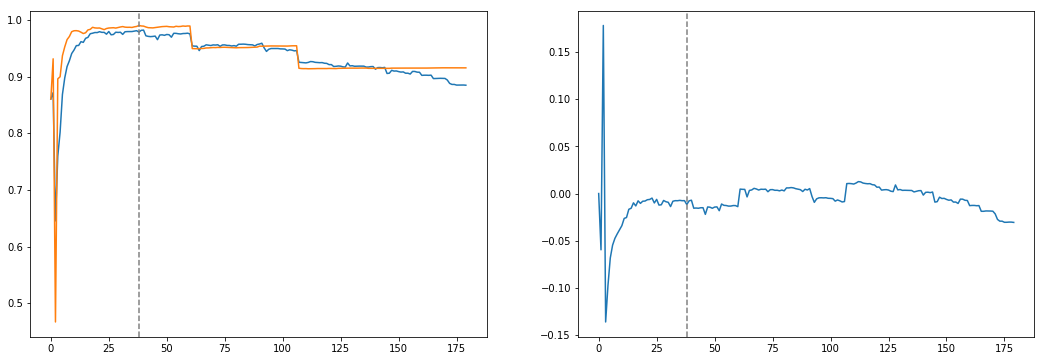

In [102]:
m = 25

fig = plt.figure(figsize=(18,6))

vif = np.linalg.inv(datasets[1][:m].corr().values).diagonal()

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(vif)))]))).data.numpy()[0])
ax.plot(true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor([np.hstack(
    (x_input, sorted(vif)))]))).data.numpy()[0] - true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

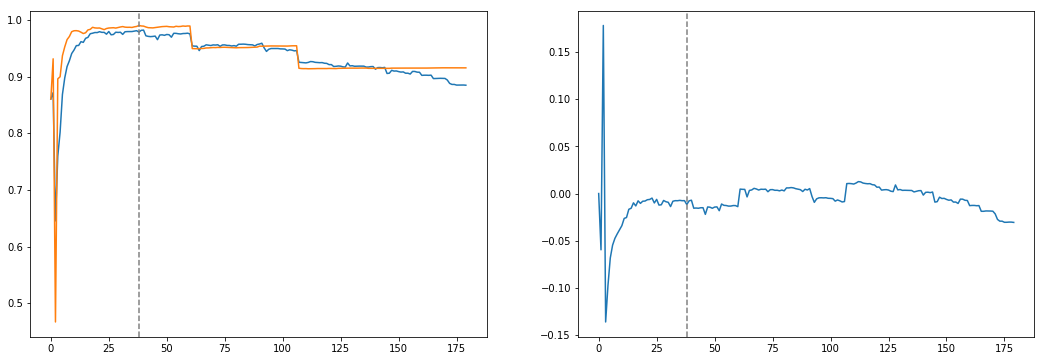

In [103]:
m = 35

fig = plt.figure(figsize=(18,6))

vif = np.linalg.inv(datasets[1][:m].corr().values).diagonal()

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(vif)))]))).data.numpy()[0])
ax.plot(true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor([np.hstack(
    (x_input, sorted(vif)))]))).data.numpy()[0] - true_results[1][:, -1])
plt.axvline(x=38, linestyle='--', color='grey')

Plot error for m in range($m^*$)

In [110]:
m_ = 38

all_diff = []
for m in range(1, m_):
    vif = np.linalg.inv(datasets[1][:m].corr().values).diagonal()
    diff = (net(Variable(torch.FloatTensor([np.hstack( (x_input, sorted(vif)))]))).data.numpy()[0] - 
            true_results[1][:, -1])[m_]
    all_diff.append(diff)

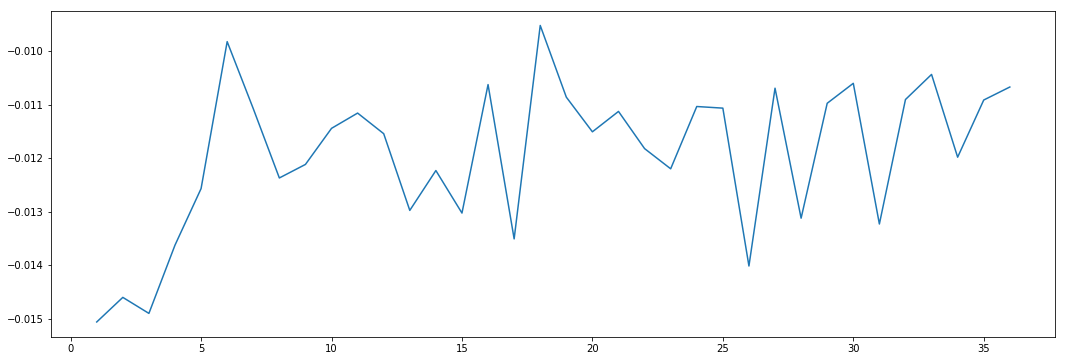

In [117]:
fig = plt.figure(figsize=(18,6))

plt.plot(all_diff)

---

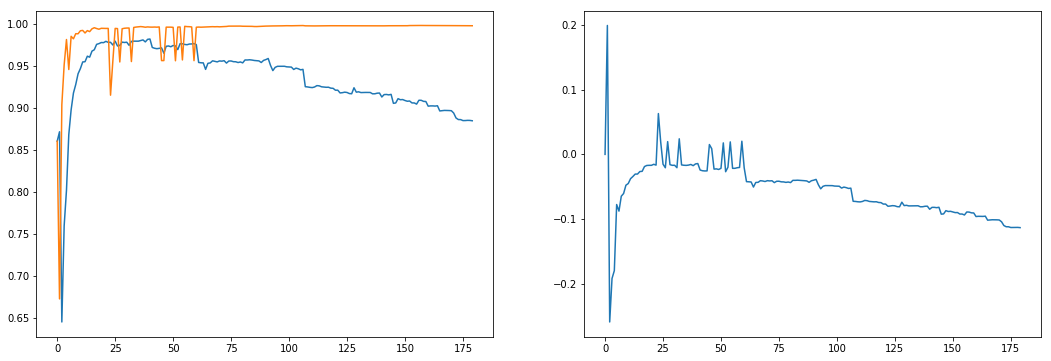

In [61]:
fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(121)
ax.plot(net(Variable(torch.FloatTensor([np.hstack((x_input, sorted(verify_vifs[0][-1])))]))).data.numpy()[0])
ax.plot(verify_results[0][:, -1])

ax = fig.add_subplot(122)
ax.plot(net(Variable(torch.FloatTensor([np.hstack(
    (x_input, sorted(verify_vifs[0][-1])))]))).data.numpy()[0] - verify_results[0][:, -1])